In [1]:
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import ot
import pickle
import seaborn as sns
import time
import warnings

import condo

In [2]:
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('font', size=7) #controls default text size
plt.rc('axes', titlesize=7) #fontsize of the title
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('legend', fontsize=7) #fontsize of the legend
plt.ioff();

In [3]:
N_T = 200
N_S = 100

# How batch effect affects S
batch_m = 2
batch_b = 5

# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

noise_setting = "NoiseFree"
targetshift_setting = "TargetShift"
featureshift_setting = "FeatureShift"
assert noise_setting in ("Noisy", "NoiseFree")
assert targetshift_setting in ("NoTargetShift", "TargetShift")
assert featureshift_setting in ("NoFeatureShift", "FeatureShift")

prob_settings = ["Homoscedastic Linear", "Heteroscedastic Linear", "Nonlinear"]
lscale_settings = ["dynamic", 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

num_probs = len(prob_settings)

rMSEs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
rMSEs_test = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
num_random = 5
for rix in range(num_random):
    rng = np.random.RandomState(rix)

    for pix, prob_setting in enumerate(prob_settings):
        # Distribution of confounders
        X_T = np.sort(rng.uniform(0, 8, size=(N_T,)))
        if targetshift_setting == "TargetShift":
            X_S = np.sort(rng.uniform(4, 8, size=(N_S,)))
            X_S_test = np.sort(rng.uniform(0, 8, size=(N_S,)))
        elif targetshift_setting == "NoTargetShift":
            X_S = np.sort(rng.uniform(0, 8, size=(N_S,)))
            X_S_test = np.sort(rng.uniform(0, 8, size=(N_S,)))

        if prob_setting == "Homoscedastic Linear":
            # How confounder X affects the distribution of T and S
            theta_m = 4
            theta_b = 1
            phi_m = 0
            phi_b = 2
            mu_T = theta_m * X_T + theta_b
            mu_S = theta_m * X_S + theta_b
            mu_S_test = theta_m * X_S_test + theta_b
            sigma_T = phi_m * X_T + phi_b
            sigma_S = phi_m * X_S + phi_b
            sigma_S_test = phi_m * X_S_test + phi_b
            T = rng.normal(mu_T, sigma_T)
            Strue = rng.normal(mu_S, sigma_S)
            Strue_test = rng.normal(mu_S_test, sigma_S_test)
        elif prob_setting == "Heteroscedastic Linear":
            # How confounder X affects the distribution of T and S
            theta_m = 4
            theta_b = 1
            phi_m = 1
            phi_b = 1
            mu_T = theta_m * X_T + theta_b
            mu_S = theta_m * X_S + theta_b
            mu_S_test = theta_m * X_S_test + theta_b
            sigma_T = phi_m * X_T + phi_b
            sigma_S = phi_m * X_S + phi_b
            sigma_S_test = phi_m * X_S_test + phi_b
            T = rng.normal(mu_T, sigma_T)
            Strue = rng.normal(mu_S, sigma_S)
            Strue_test = rng.normal(mu_S_test, sigma_S_test)
        elif prob_setting == "Nonlinear":
            # How confounder X affects the distribution of T and S
            theta_m = 4
            theta_b = 1
            phi_m = 1
            phi_b = 1
            mu_T = theta_m * (np.maximum(X_T-5, 0) ** 2) + theta_b
            mu_S = theta_m * (np.maximum(X_S-5, 0) ** 2) + theta_b
            mu_S_test = theta_m * (np.maximum(X_S_test-5, 0) ** 2) + theta_b
            sigma_T = phi_m * (np.maximum(X_T-5, 0) ** 2) + phi_b
            sigma_S = phi_m * (np.maximum(X_S-5, 0) ** 2) + phi_b
            sigma_S_test = phi_m * (np.maximum(X_S_test-5, 0) ** 2) + phi_b
            T = rng.normal(mu_T, sigma_T)
            Strue = rng.normal(mu_S, sigma_S)
            Strue_test = rng.normal(mu_S_test, sigma_S_test)
        if featureshift_setting == "FeatureShift":
            Sbatch = batch_m * Strue + batch_b
            Sbatch_test = batch_m * Strue_test + batch_b
            oracle_m = true_m
            oracle_b = true_b
        elif featureshift_setting == "NoFeatureShift":
            oracle_m = 1.0
            oracle_b = 0.0
            Sbatch = Strue.copy()
            Sbatch_test = Strue_test.copy()

        if noise_setting == "NoiseFree":
            pass
        elif noise_setting == "Noisy":
            Sbatch = Sbatch + rng.normal(0, 1, size=(N_S,))
            Sbatch_test = Sbatch_test + rng.normal(0, 1, size=(N_S,))

        T_ = T.reshape(-1, 1) # (N_T, 1)
        Strue_ = Strue.reshape(-1, 1) # (N_S, 1)
        Sbatch_ = Sbatch.reshape(-1, 1)
        X_T_ = X_T.reshape(-1, 1) # (N_T, 1)
        X_S_ = X_S.reshape(-1, 1)
        Strue_test_ = Strue_test.reshape(-1, 1) # (N_S, 1)
        Sbatch_test_ = Sbatch_test.reshape(-1, 1)
        X_S_test_ = X_S_test.reshape(-1, 1)
        print(f"rix:{rix} {prob_setting} {np.std(T_):.2f} {np.std(Strue_):.2f} {np.std(Sbatch_):.2f}")
            
        for lscale in lscale_settings:
            setting_str = f"{lscale}"

            # MMD
            method = "MMD"
            mmd_alpha = 0.01
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.MMDAdapter(
                    transform_type="location-scale",
                    optim_kwargs={"epochs": 25, "length_scale": lscale, "alpha": mmd_alpha, "beta": 0.9},
                    debug=False,
                    verbose=0,
                )
                cder.fit(Sbatch_, T_)
                Smmd_ = cder.transform(Sbatch_)
                Smmd_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Smmd_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Smmd_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting]);
            print(f"    {method}-{setting_str} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            
            method = "ConDo MMD"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.ConDoAdapter(
                    sampling="product",
                    transform_type="location-scale",
                    model_type="empirical",
                    divergence="mmd",
                    optim_kwargs={"epochs": 25, "length_scale": lscale, "alpha": 0.01, "beta": 0.9},
                    debug=False,
                    verbose=0,
                )
                cder.fit(Sbatch_, T_, X_S_, X_T_)
                Smmd_ = cder.transform(Sbatch_)
                Smmd_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Smmd_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Smmd_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting]);
            print(f"    {method}-{setting_str} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")

rix:0 Homoscedastic Linear 9.41 4.98 9.97
    MMD-dynamic rMSE: 5.340  (3.820)
    ConDo MMD-dynamic rMSE: 2.586  (1.833)
    MMD-0.001 rMSE: 48.039  (36.430)
    ConDo MMD-0.001 rMSE: 32.705  (24.936)
    MMD-0.01 rMSE: 59.605  (45.102)
    ConDo MMD-0.01 rMSE: 30.081  (22.967)
    MMD-0.1 rMSE: 79.795  (60.239)
    ConDo MMD-0.1 rMSE: 106.000  (79.890)
    MMD-1.0 rMSE: 151.493  (114.007)
    ConDo MMD-1.0 rMSE: 169.381  (127.422)
    MMD-10.0 rMSE: 234.506  (176.263)
    ConDo MMD-10.0 rMSE: 264.251  (198.570)
    MMD-100.0 rMSE: 0.540  (0.816)
    ConDo MMD-100.0 rMSE: 2.859  (2.030)
    MMD-1000.0 rMSE: 8.940  (6.413)
    ConDo MMD-1000.0 rMSE: 3.565  (2.533)
rix:0 Heteroscedastic Linear 11.40 8.48 16.95
    MMD-dynamic rMSE: 5.402  (4.365)
    ConDo MMD-dynamic rMSE: 3.073  (2.496)
    MMD-0.001 rMSE: 167.841  (137.785)
    ConDo MMD-0.001 rMSE: 193.056  (158.924)
    MMD-0.01 rMSE: 82.744  (68.245)
    ConDo MMD-0.01 rMSE: 29.977  (24.875)
    MMD-0.1 rMSE: 67.750  (55.914)
    

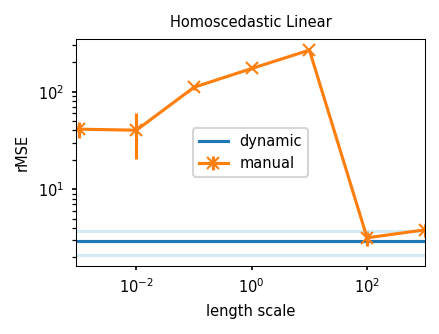

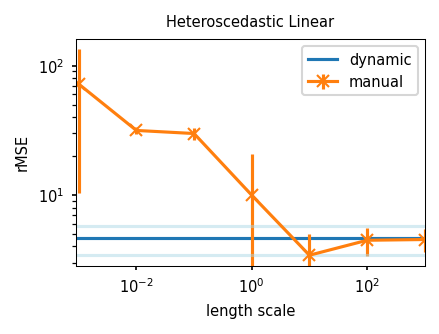

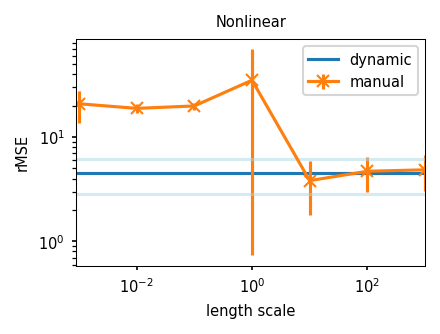

In [11]:
for prob_setting in prob_settings:
    fig = plt.figure(dpi=150, figsize=(3, 2))
    # skip true (always 0)
    plot_rmses = -1 * np.ones((len(lscale_settings), num_random)) 
    for ix, lscale in enumerate(lscale_settings):
        plot_rmses[ix, :] = np.array(rMSEs[f"{lscale}"]["ConDo MMD"][prob_setting])

    dynval = np.mean(plot_rmses[0, :])
    dynstd = np.std(plot_rmses[0, :])
    plt.plot(np.array([0.0009, 1001]), np.array([dynval, dynval]));

    """
    tgtval = np.mean(plot_rmses[1, :])
    plt.plot(np.array([0.0009, 1001]), np.array([tgtval, tgtval]));
    srcval = np.mean(plot_rmses[2, :])
    plt.plot(np.array([0.0009, 1001]), np.array([srcval, srcval]));
    initval = np.mean(plot_rmses[3, :])
    plt.plot(np.array([0.0009, 1001]), np.array([initval, initval]));
    """
    plt.errorbar(
        np.array(lscale_settings[1:]),
        np.mean(plot_rmses[1:, :], axis=1),
        yerr=np.std(plot_rmses[1:, :], axis=1), marker='x');
    plt.ylabel('rMSE');
    plt.xlabel('length scale');
    plt.xscale('log');
    plt.yscale('log');
    plt.title(prob_setting);
    plt.xlim(0.0009, 1001);
    plt.legend(lscale_settings[0:1] + ["manual"]);
    plt.plot(np.array([0.0009, 1001]), np.array([dynval+dynstd, dynval+dynstd]), 'lightblue', alpha=0.5);
    plt.plot(np.array([0.0009, 1001]), np.array([dynval-dynstd, dynval-dynstd]), 'lightblue', alpha=0.5);
    figname = f"figure-condo-mmd-dynamic-{prob_setting}-rmses-{num_random}.pdf"
    fig.savefig(figname, bbox_inches="tight")
plt.show()